In [1]:
# example of fitting an AUXULIARY CLASSIFIER gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

# mount from your google drive if your data located in your drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
df = pd.read_csv('outfinaltest890.csv', header=None, names=['A','B','Label'])

print(df.shape)
print(df['Label'].unique())
display(df.head())

(99999, 3)
[3 2 1 0]


,A,B,Label
0,0.0001,1.576538,3
1,0.0002,0.737152,3
2,0.0003,0.905151,3
3,0.0004,1.263733,3
4,0.0005,0.971985,3


(5000, 3)


<Axes: ylabel='B'>

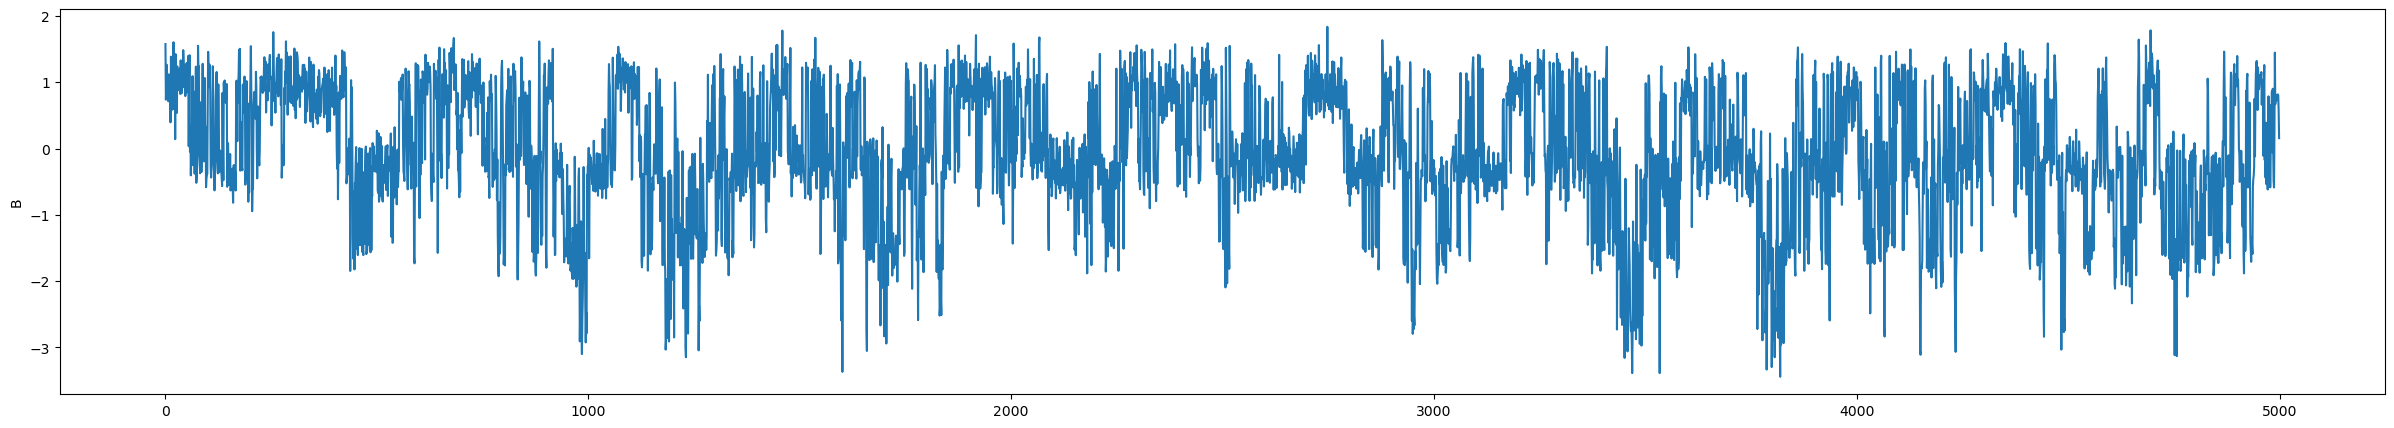

In [11]:
sample = df.iloc[0:5000,:]
print(sample.shape)
pyplot.figure(figsize=(30,5))
sns.lineplot(x=sample.index, y='B', data=sample, hue=None)

# Define Generator and Discriminator

In [5]:
# define the standalone discriminator model
def define_discriminator(in_shape=(384,1), n_classes=4):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    
    # image input
    in_image = Input(shape=in_shape)
    
    # downsample to 14x14
    fe = Conv1D(16, 3, strides=2, padding='same')(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    
    # normal
    fe = Conv1D(32, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    
    # downsample to 7x7
    fe = Conv1D(64, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    
    #downsample one more
    fe = Conv1D(128, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
   
    # flatten feature maps
    fe = Flatten()(fe)
    
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    
    # define model
    model = Model(in_image, [out1, out2])
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # binary for real/fake loss; categorical for class label loss
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    model.summary()
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=4):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    depth = 32 
    ks = 3
    dropout = 0.25
    dim = 96 
    
    # label input
    in_label = Input(shape=(1,))
    # input은 (1,)의 shape로 수행
    
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    #li는 embedding 층으로 input 데이터를 (4,50)사이즈로 변환
    
    # linear multiplication
    n_nodes = 96 * 1
    li = Dense(n_nodes)(li)
    #4, 50 의 입력을 받아 96개의 노드의 출력 (96,1)의 shape 
    # reshape to additional channel
    li = Reshape((96, 1, 1))(li)
    # reshape 함수로 (96,1,1)
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # in_lat은 latent_dim(100,)의 input을 받음
    
    # foundation for 7x7 image
    n_nodes = dim*depth
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((dim, 1, depth))(gen)
    #(100,)의 입력을 받아 96 * 32 의 노드의 출력 (96* 32,)을 relu 함수 적용 후 reshape( 96, 1, 32) 
    
    # merge image gen and label input
    merge = Concatenate()([gen, li]) #gen=96,1,32 x li=96,1,1
    #merge 층으로 gen 과 li 병합 ( 96, 1, 33)
    
    # upsample to 192,1,16
    gen = Conv2DTranspose(16, 3, strides=(2,1), padding='same')(merge)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # 업샘플링 과정 
    
    #upsample to  384,1,8
    gen = Conv2DTranspose(8, 3, strides=(2,1), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    #upsamsple
    #gen = Conv2DTranspose(48, (3,3), strides=(2,1), padding='same', kernel_initializer=init)(gen)
    #gen = BatchNormalization()(gen)
    #gen = Activation('relu')(gen)
    #384 x 1 property image
    gen = Reshape((384,-1))(gen)
    # upsample to 28x28
    #gen = Conv1DTranspose(1, 3, padding='same', kernel_initializer=init)(gen)
    gen = Conv1D(1, 3, strides=1, padding='same')(gen)
    
    out_layer = Activation('tanh')(gen)
    
    # define model
    model = Model([in_lat, in_label], out_layer)
    model.summary()
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

# Define Real Samples from Real Data

In [34]:
# load images
def load_real_samples():
    # load dataset
    df29 = pd.read_csv('outfinaltest890.csv',header=None)
    
    # get only timeseries data values + class labels
    dataset=df29.values
    dataset = dataset.astype('float64')
    dataxy=dataset[:,1:]
    
    # make new array contains of value from first column
    timep=np.zeros([len(dataset),])
    timep=dataset[:,0]
    
    # get maximum value from class labels
    maxer=np.amax(dataset[:,2])
    print ('maxer:', maxer)
    
    # create maximum channel
    maxeri=maxer.astype('int')
    maxchannels=maxeri
    
    # make new array contains of value from class labels
    idataset=np.zeros([len(dataset),],dtype=int)
    print('idataset.shape : ',len(idataset))
    idataset=dataset[:,2]
    idataset=idataset.astype(int)
    
    # split into data and label
    X_train = dataset[:,1]
    y_train = idataset[:]
    
    # data normalization and segmentation
    scaler = MinMaxScaler(copy=False)
    window=384
    n = ((np.where(np.any(dataxy, axis=1))[0][-1] + 1) // window) * window
    print('n:',n)
    xx = scaler.fit_transform(dataxy[:n,0].reshape(-1,1))
    y_train = dataxy[:(n-window),1].reshape(-1,1)
    print(f'xx : {len(xx)}, y_train : {len(y_train)}')
    
    # make to matrix
    X_train = np.asarray([xx[i:i+window] for i in range (n - window)])
    #y_train = np.asarray([y_train[i:i+window] for i in range (n - window)])
    #trainX=X_train.copy()
    
    X = X_train.copy()
    y = y_train.copy()
    
    #X = xx.copy()
    #(trainXX, trainyy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    #X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    #X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    
    X = (X - 127.5) / 127.5
    print(X.shape, y.shape)
    
    return [X, y]

In [35]:
load_real_samples()

maxer: 3.0
idataset.shape :  99999
n: 99840
xx : 99840, y_train : 99456
(99456, 384, 1) (99456, 1)


[array([[[-0.99279098],
         [-0.99395531],
         [-0.99372227],
         ...,
         [-0.99426496],
         [-0.99342617],
         [-0.9946324 ]],
 
        [[-0.99395531],
         [-0.99372227],
         [-0.99322488],
         ...,
         [-0.99342617],
         [-0.9946324 ],
         [-0.99357559]],
 
        [[-0.99372227],
         [-0.99322488],
         [-0.99362957],
         ...,
         [-0.9946324 ],
         [-0.99357559],
         [-0.99448233]],
 
        ...,
 
        [[-0.99565618],
         [-0.99692019],
         [-0.99568687],
         ...,
         [-0.99346363],
         [-0.99322996],
         [-0.99344606]],
 
        [[-0.99692019],
         [-0.99568687],
         [-0.99575947],
         ...,
         [-0.99322996],
         [-0.99344606],
         [-0.99309958]],
 
        [[-0.99568687],
         [-0.99575947],
         [-0.99707787],
         ...,
         [-0.99344606],
         [-0.99309958],
         [-0.9937428 ]]]),
 array([[3.],
     

# Define Real and Fake Samples

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    
    # select images and labels
    X, labels = images[ix], labels[ix]
    
    # generate class labels
    y = ones((n_samples, 1))
    #  실제 데이터에서 sanple 만큼의 데이터와 레이블을 추출하고 y값은 모두 1(True)
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=4):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    
    # generate random fake labels start from 0 to n_clasess as many as n_samples
    labels = randint(0, n_classes, n_samples) #check these labels!
    # 데이터는 셈플 개수와 latent_dimm 의 형태를 한 랝덤 int 데이터와  샘플 개수만큼의 label을 출력한다. 
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    
    # predict outputs
    images = generator.predict([z_input, labels_input])
    #랜덤 노이즈를 통하여 생성기 모델에 입력 -> 샘플 개수만큼의 fake 데이터 생성, 
    
    # create class labels
    y = zeros((n_samples, 1))
    # 샘플의 개수만큼 0(가짜 레이블을 의미) 의 데이터 ( 정답 데이터 ) 생성
    
    return [images, labels_input], y
# 함수의 출력은 샘플 개수의 가짜 이미지, 0~3 사이의 레이블 정답 데이터, 샘플 개수의 0( 진짜/가짜 정답 데이터) 


# Define Performance Summary

In [8]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, nmn_label], nmn_y = generate_fake_samples(g_model, latent_dim, n_samples) #TODO!:Numan (nmns were _ and _) - change labels in this row and debug!
    # X는 fake 이미지, nmn_label은 가짜 이미지의 label, nmn_y 는 가짜 이미지의 정답 데이터 (0)
    
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        
        # turn off axis
        pyplot.axis('off')
        
        # plot raw pixel data
        pyplot.imshow(X[i, :], cmap='gray_r')
    #생성한 100개의 fake 이미지 출력
    
#         np.savetxt('test_raw_nc%d%d.csv' % (i,step), X[i,:], delimiter=',')
#         np.savetxt('test_cat_nc%d%d.csv' % (i,step), nmn_label[i],delimiter=',')
    
    # save plot to file
    #np.savetxt('test_raw_nc%d.csv' % (step), X[:,:,0], delimiter=',')
    #np.savetxt('test_cat_nc%d.csv' % (step), nmn_label[:],delimiter=',')
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))
    print('success')

# Training AC-GAN

In [9]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_evals=100):
    
    # calculate the number of batches per training epoch
    # 각 epoch 마다 배치의 숫자 계산 
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    print('batch per epoch: %d' % bat_per_epo)
    
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print('number of steps: %d' % n_steps)
    
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # 정답 데이터 추출
        
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # train_on_batch 는 배치 단위로모델을 학습할 때 사용
        # d_r1과 d_r2 는 각각  진짜/가짜예측과 데이터의 레이블 예측에 대한 손실함수
            
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # 가짜 데이터 생성
        
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # d_f와 d_f2는 각각 진짜/가짜 예측값 및 데이터 레이블 예측에 대한 손실함수
        
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        #  n_batch 만큼의 랜덤 노이즈 데이터 생성
        
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # n 배치 만큼의 1 데이터 (fake sample의 label)
        
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # 잡음을 입력하여 생성자 모델 훈련
        
        # summarize loss on this batch
        if (i+1) % n_evals == 0:
            print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

In [10]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()

# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 192, 16)      64          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 192, 16)      0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 192, 16)      0           ['leaky_re_lu[0][0]']            
                                                                                              

C:\Users\procns\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 3072)         310272      ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        200         ['input_2[0][0]']                
                                                                                            

1/1 [==============================] - 0s 31ms/step
>300, dr[0.230,1.315], df[0.169,0.082], g[1.200,0.066]
1/1 [==============================] - 0s 31ms/step
>400, dr[0.121,1.390], df[0.189,0.046], g[2.869,0.099]
1/1 [==============================] - 0s 31ms/step
>500, dr[0.283,1.542], df[0.374,0.048], g[3.834,0.142]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step
>600, dr[0.042,1.335], df[0.237,0.023], g[2.332,0.218]
1/1 [==============================] - 0s 31ms/step
>700, dr[0.181,1.301], df[0.133,0.038], g[2.007,0.179]
1/1 [==============================] - 0s 16ms/step
>800, dr[0.125,1.664], df[0.243,0.038], g[2.019,0.251]
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step
>900, dr[0.321,1.113], df[0.182,0.036], g[4.959,0.315]
1/1 [==============================] - 0s 31ms/step
>1000, dr[0.412,1.455], df[0.504,0.079], g[7.684,0.507]
1/1 [==============================] - 0s 31ms/step
>1100, dr[0.014,1.142], df[0.227,0.026], g[5.491,0.186]
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step
>1200, dr[0.033,1.102], df[0.039,0.071], g[6.428,0.234]
1/1 [==============================] - 0s 31ms/step
>1300, dr[0.727,1.414], df[0.750,0.505], g[26.332,3.088]
1/1 [==============================] - 0s 31ms/step
>1400, dr[0.584,1.361], df[0.722,0.147], g[23.538,1.398]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>1500, dr[0.456,1.025], df[0.286,0.075], g[4.549,0.277]
4/4 [==============================] - 0s 10ms/step
>Saved: generated_plot_1554.png and model_1554.h5
success
1/1 [==============================] - 0s 31ms/step
>1600, dr[0.067,1.037], df[0.023,0.124], g[9.780,0.238]
1/1 [==============================] - 0s 31ms/step
>1700, dr[0.011,1.058], df[0.002,0.017], g[19.198,0.109]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>1800, dr[0.011,1.177], df[0.016,0.057], g[7.861,0.169]
1/1 [==============================] - 0s 31ms/step
>1900, dr[0.047,1.299], df[0.044,0.011], g[6.049,0.140]
1/1 [==============================] - 0s 31ms/step
>2000, dr[0.036,1.272], df[0.018,0.056], g[5.132,0.368]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>2100, dr[0.219,1.179], df[0.230,0.030], g[0.772,0.133]
1/1 [==============================] - 0s 16ms/step
>2200, dr[0.431,1.395], df[0.381,0.030], g[0.280,0.157]
1/1 [==============================] - 0s 31ms/step
>2300, dr[0.031,1.184], df[0.054,0.012], g[0.087,0.049]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>2400, dr[0.007,1.039], df[0.011,0.006], g[0.507,0.015]
1/1 [==============================] - 0s 36ms/step
>2500, dr[0.018,0.987], df[0.005,0.007], g[1.215,0.053]
1/1 [==============================] - 0s 35ms/step
>2600, dr[0.021,1.134], df[0.012,0.090], g[0.992,1.125]
1/1 [==============================] - 0s 31ms/step
>2700, dr[0.007,1.217], df[0.000,0.144], g[0.185,0.454]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>2800, dr[0.001,1.127], df[0.000,0.004], g[0.075,0.044]
1/1 [==============================] - 0s 43ms/step
>2900, dr[0.034,1.160], df[0.000,0.008], g[1.067,0.020]
1/1 [==============================] - 0s 31ms/step
>3000, dr[0.001,1.115], df[0.000,0.025], g[0.327,0.095]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>3100, dr[0.001,1.097], df[0.000,0.025], g[0.348,0.106]
4/4 [==============================] - 0s 12ms/step
>Saved: generated_plot_3108.png and model_3108.h5
success
1/1 [==============================] - 0s 31ms/step
>3200, dr[0.000,0.929], df[0.000,0.006], g[0.178,0.039]
1/1 [==============================] - 0s 37ms/step
>3300, dr[0.000,1.100], df[0.000,0.032], g[0.840,0.058]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>3400, dr[0.000,1.245], df[0.000,0.026], g[1.180,0.114]
1/1 [==============================] - 0s 31ms/step
>3500, dr[0.000,0.967], df[0.000,0.059], g[1.517,0.096]
1/1 [==============================] - 0s 31ms/step
>3600, dr[0.000,1.089], df[0.000,0.147], g[0.983,0.126]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step
>3700, dr[0.001,1.203], df[0.000,0.040], g[0.598,0.027]
1/1 [==============================] - 0s 31ms/step
>3800, dr[0.000,0.907], df[0.000,0.118], g[0.710,0.004]
1/1 [==============================] - 0s 31ms/step
>3900, dr[0.000,0.987], df[0.000,0.003], g[1.302,0.063]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 51ms/step
>4000, dr[0.000,0.893], df[0.000,0.030], g[1.897,0.068]
1/1 [==============================] - 0s 47ms/step
>4100, dr[0.000,0.915], df[0.000,0.100], g[1.280,0.109]
1/1 [==============================] - 0s 31ms/step
>4200, dr[0.000,0.988], df[0.000,0.008], g[0.494,0.010]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>4300, dr[0.000,1.147], df[0.000,0.003], g[0.733,0.042]
1/1 [==============================] - 0s 31ms/step
>4400, dr[0.000,1.151], df[0.000,0.021], g[0.398,0.020]
1/1 [==============================] - 0s 31ms/step
>4500, dr[0.000,0.998], df[0.000,0.014], g[0.106,0.145]
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 31ms/step
>4600, dr[0.000,1.007], df[0.000,0.025], g[0.406,0.104]
4/4 [==============================] - 0s 15ms/step
>Saved: generated_plot_4662.png and model_4662.h5
success
1/1 [==============================] - 0s 31ms/step
>4700, dr[0.000,1.102], df[0.000,0.009], g[0.095,0.009]
1/1 [==============================] - 0s 31ms/step
>4800, dr[0.000,0.854], df[0.000,0.001], g[0.118,0.018]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>4900, dr[0.000,0.836], df[0.000,0.000], g[0.166,0.011]
1/1 [==============================] - 0s 47ms/step
>5000, dr[0.000,0.951], df[0.000,0.002], g[0.110,0.014]
1/1 [==============================] - 0s 47ms/step
>5100, dr[0.000,1.059], df[0.000,0.006], g[0.093,0.013]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>5200, dr[0.000,1.010], df[0.000,0.010], g[0.028,0.003]
1/1 [==============================] - 0s 31ms/step
>5300, dr[0.000,1.013], df[0.000,0.001], g[0.068,0.006]
1/1 [==============================] - 0s 31ms/step
>5400, dr[0.000,1.200], df[0.000,0.001], g[0.030,0.063]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step
>5500, dr[0.000,1.019], df[0.000,0.001], g[0.027,0.000]
1/1 [==============================] - 0s 47ms/step
>5600, dr[0.000,0.873], df[0.000,0.008], g[0.016,0.028]
1/1 [==============================] - 0s 31ms/step
>5700, dr[0.000,0.946], df[0.000,0.001], g[0.014,0.004]
1/1 [==============================] - 0s 31ms/step
>5800, dr[0.000,0.854], df[0.000,0.000], g[0.044,0.000]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step
>5900, dr[0.000,1.224], df[0.000,0.000], g[0.021,0.000]
1/1 [==============================] - 0s 31ms/step
>6000, dr[0.000,0.752], df[0.000,0.000], g[0.004,0.000]
1/1 [==============================] - 0s 47ms/step
>6100, dr[0.000,0.871], df[0.000,0.000], g[0.010,0.002]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step
>6200, dr[0.000,0.928], df[0.000,0.000], g[0.058,0.001]
4/4 [==============================] - 0s 21ms/step
>Saved: generated_plot_6216.png and model_6216.h5
success
1/1 [==============================] - 0s 47ms/step
>6300, dr[0.000,1.017], df[0.000,0.002], g[0.035,0.038]
1/1 [==============================] - 0s 49ms/step
>6400, dr[0.000,0.870], df[0.000,0.000], g[0.024,0.001]
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step
>6500, dr[0.000,0.865], df[0.000,0.000], g[0.019,0.002]
1/1 [==============================] - 0s 31ms/step
>6600, dr[0.000,0.988], df[0.000,0.000], g[0.010,0.001]
1/1 [==============================] - 0s 47ms/step
>6700, dr[0.000,0.815], df[0.000,0.001], g[0.002,0.000]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 56ms/step
>6800, dr[0.000,1.178], df[0.000,0.001], g[0.055,0.006]
1/1 [==============================] - 0s 31ms/step
>6900, dr[0.000,0.730], df[0.000,0.001], g[0.044,0.004]
1/1 [==============================] - 0s 31ms/step
>7000, dr[0.000,0.672], df[0.000,0.000], g[0.040,0.001]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 43ms/step
>7100, dr[0.000,0.567], df[0.000,0.000], g[0.028,0.002]
1/1 [==============================] - 0s 36ms/step
>7200, dr[0.000,1.039], df[0.000,0.001], g[0.013,0.000]
1/1 [==============================] - 0s 31ms/step
>7300, dr[0.000,0.868], df[0.000,0.000], g[0.019,0.035]
1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 47ms/step
>7400, dr[0.000,0.849], df[0.000,0.000], g[0.009,0.000]
1/1 [==============================] - 0s 47ms/step
>7500, dr[0.000,0.777], df[0.000,0.000], g[0.074,0.007]
1/1 [==============================] - 0s 31ms/step
>7600, dr[0.000,0.691], df[0.000,0.000], g[0.062,0.008]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 53ms/step
>7700, dr[0.000,0.890], df[0.000,0.001], g[0.133,0.031]
4/4 [==============================] - 0s 21ms/step
>Saved: generated_plot_7770.png and model_7770.h5
success
1/1 [==============================] - 0s 33ms/step
>7800, dr[0.000,0.446], df[0.000,0.003], g[0.046,0.025]
1/1 [==============================] - 0s 47ms/step
>7900, dr[0.000,1.177], df[0.000,0.001], g[0.013,0.000]
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step
>8000, dr[0.000,0.673], df[0.000,0.001], g[0.073,0.006]
1/1 [==============================] - 0s 47ms/step
>8100, dr[0.000,0.536], df[0.000,0.008], g[0.031,0.002]
1/1 [==============================] - 0s 31ms/step
>8200, dr[0.000,0.633], df[0.000,0.000], g[0.143,0.000]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step
>8300, dr[0.000,0.753], df[0.000,0.007], g[0.022,0.019]
1/1 [==============================] - 0s 31ms/step
>8400, dr[0.000,0.688], df[0.000,0.001], g[0.020,0.002]
1/1 [==============================] - 0s 31ms/step
>8500, dr[0.000,0.779], df[0.000,0.001], g[0.009,0.001]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step
>8600, dr[0.000,0.752], df[0.000,0.001], g[0.004,0.002]
1/1 [==============================] - 0s 47ms/step
>8700, dr[0.000,0.725], df[0.000,0.000], g[0.004,0.001]
1/1 [==============================] - 0s 47ms/step
>8800, dr[0.000,0.915], df[0.000,0.000], g[0.003,0.000]
1/1 [==============================] - 0s 47ms/step
>8900, dr[0.000,0.720], df[0.000,0.001], g[0.011,0.012]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 39ms/step
>9000, dr[0.000,0.701], df[0.000,0.000], g[0.008,0.001]
1/1 [==============================] - 0s 47ms/step
>9100, dr[0.000,0.511], df[0.000,0.001], g[0.013,0.001]
1/1 [==============================] - 0s 48ms/step
>9200, dr[0.000,0.387], df[0.000,0.001], g[0.006,0.001]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step
>9300, dr[0.000,0.691], df[0.000,0.028], g[0.014,0.002]
4/4 [==============================] - 0s 28ms/step
>Saved: generated_plot_9324.png and model_9324.h5
success
1/1 [==============================] - 0s 47ms/step
>9400, dr[0.000,0.969], df[0.000,0.002], g[0.024,0.001]
1/1 [==============================] - 0s 48ms/step
>9500, dr[0.000,0.466], df[0.000,0.004], g[0.001,0.003]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 57ms/step
>9600, dr[0.000,0.545], df[0.000,0.000], g[0.004,0.000]
1/1 [==============================] - 0s 47ms/step
>9700, dr[0.000,0.618], df[0.000,0.000], g[0.004,0.000]
1/1 [==============================] - 0s 73ms/step
>9800, dr[0.000,0.542], df[0.000,0.000], g[0.019,0.000]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 53ms/step
>9900, dr[0.000,0.729], df[0.000,0.000], g[0.013,0.005]
1/1 [==============================] - 0s 50ms/step
>10000, dr[0.000,0.505], df[0.000,0.019], g[0.111,0.029]
1/1 [==============================] - 0s 63ms/step
>10100, dr[0.000,0.948], df[0.000,0.004], g[0.068,0.005]
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 47ms/step
>10200, dr[0.000,0.492], df[0.000,0.027], g[0.042,0.003]
1/1 [==============================] - 0s 40ms/step
>10300, dr[0.000,0.452], df[0.000,0.043], g[0.033,0.012]
1/1 [==============================] - 0s 47ms/step
>10400, dr[0.000,0.585], df[0.000,0.000], g[0.110,0.101]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step
>10500, dr[0.000,0.667], df[0.000,0.001], g[0.245,0.021]
1/1 [==============================] - 0s 47ms/step
>10600, dr[0.000,0.540], df[0.000,0.018], g[0.313,0.043]
1/1 [==============================] - 0s 47ms/step
>10700, dr[0.000,0.379], df[0.000,0.026], g[0.407,0.048]
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 62ms/step
>10800, dr[0.000,0.588], df[0.000,0.000], g[0.070,0.013]
4/4 [==============================] - 0s 28ms/step
>Saved: generated_plot_10878.png and model_10878.h5
success
1/1 [==============================] - 0s 47ms/step
>10900, dr[0.000,0.468], df[0.000,0.007], g[0.033,0.014]
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 62ms/step
>11000, dr[0.000,0.549], df[0.000,0.000], g[0.009,0.002]
1/1 [==============================] - 0s 52ms/step
>11100, dr[0.000,0.685], df[0.000,0.000], g[0.019,0.005]
1/1 [==============================] - 0s 47ms/step
>11200, dr[0.000,0.453], df[0.000,0.109], g[0.266,0.012]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step
>11300, dr[0.000,0.566], df[0.000,0.021], g[0.347,0.066]
1/1 [==============================] - 0s 47ms/step
>11400, dr[0.000,0.510], df[0.000,0.093], g[0.669,0.082]
1/1 [==============================] - 0s 47ms/step
>11500, dr[0.000,0.718], df[0.000,0.064], g[0.970,0.195]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 62ms/step
>11600, dr[0.000,0.436], df[0.000,0.013], g[0.446,0.129]
1/1 [==============================] - 0s 47ms/step
>11700, dr[0.000,0.648], df[0.000,0.025], g[0.159,0.087]
1/1 [==============================] - 0s 47ms/step
>11800, dr[0.000,0.568], df[0.000,0.001], g[0.052,0.013]
1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 47ms/step
>11900, dr[0.000,0.578], df[0.000,0.004], g[0.054,0.010]
1/1 [==============================] - 0s 63ms/step
>12000, dr[0.000,0.600], df[0.000,0.001], g[0.200,0.049]
1/1 [==============================] - 0s 47ms/step
>12100, dr[0.000,0.758], df[0.000,0.006], g[0.182,0.021]
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step
>12200, dr[0.000,0.447], df[0.000,0.000], g[0.072,0.033]
1/1 [==============================] - 0s 47ms/step
>12300, dr[0.000,0.456], df[0.000,0.001], g[0.061,0.004]
1/1 [==============================] - 0s 62ms/step
>12400, dr[0.000,0.670], df[0.000,0.005], g[0.075,0.004]
4/4 [==============================] - 0s 33ms/step
>Saved: generated_plot_12432.png and model_12432.h5
success
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 62ms/step
>12500, dr[0.000,0.343], df[0.000,0.003], g[0.030,0.000]
1/1 [==============================] - 0s 62ms/step
>12600, dr[0.000,0.537], df[0.000,0.001], g[0.058,0.020]
1/1 [==============================] - 0s 47ms/step
>12700, dr[0.000,0.539], df[0.000,0.021], g[0.140,0.004]
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 74ms/step
>12800, dr[0.000,0.400], df[0.000,0.000], g[0.008,0.000]
1/1 [==============================] - 0s 78ms/step
>12900, dr[0.000,0.525], df[0.000,0.000], g[0.034,0.000]
1/1 [==============================] - 0s 95ms/step
>13000, dr[0.000,1.527], df[0.000,0.000], g[0.000,0.014]
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 62ms/step
>13100, dr[0.000,0.525], df[0.000,0.000], g[0.005,0.001]
1/1 [==============================] - 0s 79ms/step
>13200, dr[0.000,0.506], df[0.000,0.000], g[0.001,0.009]
1/1 [==============================] - 0s 72ms/step
>13300, dr[0.000,0.393], df[0.000,0.000], g[0.019,0.000]
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 75ms/step
>13400, dr[0.000,0.547], df[0.000,0.000], g[0.004,0.000]
1/1 [==============================] - 0s 87ms/step
>13500, dr[0.000,0.354], df[0.000,0.000], g[0.000,0.000]
1/1 [==============================] - 0s 80ms/step
>13600, dr[0.000,0.450], df[0.000,0.000], g[0.014,0.000]
1/1 [==============================] - 0s 88ms/step
>13700, dr[0.000,0.511], df[0.000,0.000], g[0.005,0.004]
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step
>13800, dr[0.000,0.591], df[0.000,0.000], g[0.002,0.020]
1/1 [==============================] - 0s 90ms/step
>13900, dr[0.000,1.119], df[0.000,0.000], g[0.004,0.001]
4/4 [==============================] - 0s 55ms/step
>Saved: generated_plot_13986.png and model_13986.h5
success
1/1 [==============================] - 0s 94ms/step
>14000, dr[0.000,0.303], df[0.000,0.000], g[0.004,0.002]
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 94ms/step
>14100, dr[0.000,0.422], df[0.000,0.000], g[0.012,0.000]
1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 95ms/step
>14200, dr[0.000,0.564], df[0.000,0.000], g[0.013,0.000]
1/1 [==============================] - 0s 103ms/step
>14300, dr[0.000,0.418], df[0.000,0.000], g[0.006,0.002]
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 111ms/step
>14400, dr[0.000,0.337], df[0.000,0.000], g[0.003,0.003]
1/1 [==============================] - 0s 78ms/step
>14500, dr[0.000,0.576], df[0.000,0.000], g[0.003,0.001]
1/1 [==============================] - 0s 62ms/step
>14600, dr[0.000,0.601], df[0.000,0.000], g[0.036,0.017]
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 85ms/step
>14700, dr[0.000,1.875], df[0.000,0.157], g[0.124,0.015]
1/1 [==============================] - 0s 62ms/step
>14800, dr[0.000,0.533], df[0.000,0.000], g[0.028,0.002]
1/1 [==============================] - 0s 62ms/step
>14900, dr[0.000,0.423], df[0.000,0.001], g[0.101,0.016]
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 69ms/step
>15000, dr[0.000,0.678], df[0.000,0.001], g[0.019,0.015]
1/1 [==============================] - 0s 69ms/step
>15100, dr[0.000,0.405], df[0.000,0.006], g[0.029,0.034]
1/1 [==============================] - 0s 62ms/step
>15200, dr[0.000,0.460], df[0.000,0.006], g[0.223,0.107]
1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 109ms/step
>15300, dr[0.000,0.835], df[0.000,0.040], g[1.024,0.110]
1/1 [==============================] - 0s 94ms/step
>15400, dr[0.001,0.483], df[0.000,0.142], g[2.936,0.237]
1/1 [==============================] - 0s 117ms/step
>15500, dr[0.000,0.652], df[0.010,0.028], g[0.868,0.398]
4/4 [==============================] - 0s 58ms/step
>Saved: generated_plot_15540.png and model_15540.h5
success


In [14]:
df29 = pd.read_csv('outfinaltest890.csv',header=None)
    
# get only timeseries data values + class labels
dataset=df29.values
dataset = dataset.astype('float64')
dataxy=dataset[:,1:]

In [19]:
dataxy

array([[ 1.576538,  3.      ],
       [ 0.737152,  3.      ],
       [ 0.905151,  3.      ],
       ...,
       [ 0.911865,  3.      ],
       [ 1.21994 ,  3.      ],
       [-0.220337,  2.      ]])